In [1]:
import sys
sys.path.append('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github')

In [ ]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df, threshold_interactions_df_plus, train_test_split_csr

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:

my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

def load_user_item_matrix(filepath):
    data = []

    with open(filepath, 'r') as f:
        while True:
            user_line = f.readline()
            if not user_line:
                break

            user_line = user_line.strip()
            if '|' not in user_line:
                continue

            user_id, num_ratings = user_line.split('|')
            user_id = int(user_id)
            num_ratings = int(num_ratings)

            for _ in range(num_ratings):
                item_line = f.readline().strip()
                parts = item_line.split('\t')
                if len(parts) < 2:
                    continue
                item_id, score = parts[0], parts[1]
                data.append([user_id, int(item_id), int(score)])

    df = pd.DataFrame(data, columns=['user_id', 'item_id', 'rating'])
    return df


In [4]:
def safe_int(x):
    return int(x) if x != 'None' else 0


def load_track_data(filepath):
    track_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            track_id = safe_int(parts[0])
            album_id = safe_int(parts[1])
            artist_id = safe_int(parts[2])
            genre_ids = [safe_int(g) for g in parts[3:]] if len(parts) > 3 else []
            track_data.append([track_id, album_id, artist_id, genre_ids])
    return pd.DataFrame(track_data, columns=['track_id', 'album_id', 'artist_id', 'genre_ids'])

def load_album_data(filepath):
    album_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            album_id = safe_int(parts[0])
            artist_id = safe_int(parts[1])
            genre_ids = [safe_int(g) for g in parts[2:]] if len(parts) > 2 else []
            album_data.append([album_id, artist_id, genre_ids])
    return pd.DataFrame(album_data, columns=['album_id', 'artist_id', 'genre_ids'])


# read artistData2
def load_artist_data(filepath):
    with open(filepath, 'r') as f:
        artist_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(artist_ids, columns=['artist_id'])

# read genreData2
def load_genre_data(filepath):
    with open(filepath, 'r') as f:
        genre_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(genre_ids, columns=['genre_id'])

In [5]:
track_df = load_track_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/trackData2.txt')
track_df

,track_id,album_id,artist_id,genre_ids
0,1,106710,281667,"[214765, 162234, 155788]"
1,2,280977,233685,"[131552, 173467, 48505]"
2,3,38422,219136,"[61215, 201738, 88853]"
3,4,119529,166863,"[17453, 35389]"
4,5,16742,294690,"[61215, 34486, 274088]"
...,...,...,...,...
224036,296100,166516,33011,"[274088, 199606, 88853]"
224037,296101,0,0,[]
224038,296102,153644,289056,"[158282, 139095, 242383]"
224039,296105,68336,6613,[82064]


In [6]:
album_df = load_album_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/albumData2.txt')
album_df

,album_id,artist_id,genre_ids
0,0,0,[214765]
1,6,228091,"[158282, 81520, 242383]"
2,19,85028,[103715]
3,30,16832,[31567]
4,33,26330,"[149962, 209270]"
...,...,...,...
52824,296104,125866,[158282]
52825,296106,221637,"[116130, 9432]"
52826,296107,0,[61215]
52827,296108,93277,[61215]


In [7]:
artist_df = load_artist_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/artistData2.txt')
artist_df

,artist_id
0,16
1,23
2,35
3,40
4,49
...,...
18669,295987
18670,296007
18671,296012
18672,296013


In [8]:
genre_df = load_genre_data('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/genreData2.txt')
genre_df

,genre_id
0,208
1,315
2,642
3,1075
4,1271
...,...
562,292093
563,293670
564,293688
565,294138


In [9]:
train_path = '/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/yahoo_data/ydata-ymusic-kddcup-2011-track2/trainIdx2.txt'
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
train_df = load_user_item_matrix(train_path)


In [10]:
train_df

,user_id,item_id,rating
0,0,28341,90
1,0,51210,90
2,0,79500,90
3,0,82317,90
4,0,98399,90
...,...,...,...
61944401,249011,270557,90
61944402,249011,273574,90
61944403,249011,286938,90
61944404,249011,287681,80


In [11]:
duplicate_counts = train_df.groupby(['user_id', 'item_id']).size()
duplicates = duplicate_counts[duplicate_counts > 1]

print(f"🔁 Number of duplicated (user_id, item_id) pairs: {len(duplicates)}")
print(duplicates.head())


🔁 Number of duplicated (user_id, item_id) pairs: 0
Series([], dtype: int64)


In [12]:
print(train_df['item_id'].max())      # highest item_id
print(track_df['track_id'].max())     # highest track_id
print(train_df['item_id'].isin(track_df['track_id']).mean())  # proportion to match

print(train_df['item_id'].isin(album_df['album_id']).mean())

print(train_df['item_id'].isin(artist_df['artist_id']).mean())

print(train_df['item_id'].isin(genre_df['genre_id']).mean())



296110
296110
0.4385845107627636
0.1925648621120041
0.3114063600835885
0.05744426704164376


In [13]:
def build_item_metadata(track_df, album_df, artist_df, genre_df):
    rows = []

    # 1. Tracks
    for _, row in track_df.iterrows():
        rows.append({
            'item_id': row['track_id'],
            'item_type': 'track',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 2. Albums
    for _, row in album_df.iterrows():
        rows.append({
            'item_id': row['album_id'],
            'item_type': 'album',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 3. Artists
    for artist_id in artist_df['artist_id']:
        rows.append({
            'item_id': artist_id,
            'item_type': 'artist',
            'artist_id': artist_id,
            'genre_ids': 0
        })

    # 4. Genres
    for genre_id in genre_df['genre_id']:
        rows.append({
            'item_id': genre_id,
            'item_type': 'genre',
            'artist_id': 0,
            'genre_ids': [genre_id]
        })

    return pd.DataFrame(rows)

In [ ]:
item_meta_df = build_item_metadata(track_df, album_df, artist_df, genre_df)

train_with_meta = train_df.merge(item_meta_df, on='item_id', how='inner')

# When loading the data, sort by a stable column (e.g., user_id)
train_with_meta = train_with_meta.sort_values('user_id').reset_index(drop=True)

train_with_meta

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,0,28341,90,artist,28341,0
1,0,232604,30,artist,232604,0
2,0,237425,50,artist,237425,0
3,0,245257,50,artist,245257,0
4,0,23301,50,artist,23301,0
...,...,...,...,...,...,...
61944401,249011,141075,90,artist,141075,0
61944402,249011,150385,80,genre,0,[150385]
61944403,249011,152077,90,artist,152077,0
61944404,249011,158282,80,genre,0,[158282]


In [67]:
filtered_df = threshold_interactions_df_plus(train_with_meta, min_items_per_user=150, min_artists_per_user=20, min_genres_per_user=10,min_users_per_item=500)

Initial: users = 249012, items = 296111, sparsity = 0.0840%
After item filtering: users = 57389, items = 17091, sparsity = 2.8936%
Final: users = 56732, items = 17091, sparsity = 2.9130%


In [68]:
filtered_df

,user_id,item_id,rating,item_type,artist_id,genre_ids
47,1,243848,70,artist,243848,0
49,1,179556,70,track,147606,"[131552, 199606]"
50,1,124282,50,artist,124282,0
52,1,22143,50,track,124282,"[293670, 212410, 88853, 51420]"
54,1,53228,70,album,243848,"[266781, 51420]"
...,...,...,...,...,...,...
61944212,249008,269073,100,artist,269073,0
61944213,249008,117381,100,album,231280,"[131552, 199606, 289568]"
61944214,249008,55618,0,track,246667,"[158282, 139095, 242383, 279143]"
61944215,249008,87732,100,track,79500,"[158282, 242383, 207648]"


In [76]:
all_user_ids = sorted(filtered_df['user_id'].unique())

def split_users_by_ratio(all_user_ids, ratio):
    n = len(all_user_ids)
    split_point = int(n * ratio)
    warm_users = all_user_ids[:split_point]
    cold_users = all_user_ids[split_point:]
    return warm_users, cold_users

# Example ratios from 10% to 50%
# ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
# splits = {r: split_users_by_ratio(all_user_ids, r) for r in ratios}


## 10% warm

In [ ]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.1)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")



In [70]:
def split_and_combine(strategy="artist-only"):
    """Handles both approaches with proper matrix alignment"""
    # Get full cold matrix and mappings
    matrix_cold, rid_to_idx_cold, _, cid_to_idx, _ = df_to_matrix(
        df_cold, "user_id", "item_id", "rating"
    )
    matrix_cold = matrix_cold.tocsr()

    # Create boolean masks
    artist_mask = np.isin(
        np.arange(matrix_cold.shape[1]), 
        [cid_to_idx[iid] for iid in df_cold[df_cold['item_type'] == 'artist']['item_id']]
    )
    genre_mask = ~artist_mask

    # Create aligned matrices
    matrix_cold_artist = matrix_cold.multiply(artist_mask)
    matrix_cold_genre = matrix_cold.multiply(genre_mask)
    matrix_cold_artist = matrix_cold.multiply(artist_mask).tocsr()
    matrix_cold_genre = matrix_cold.multiply(genre_mask).tocsr()

    al_artist, test_cold, _ = train_test_split(
        matrix_cold_artist, 
        split_count=30,
        fraction=None
    )
    
    if strategy == "artist-only":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)  
        return K_cold, X_cold, test_cold
    
    elif strategy == "hybrid":
        combined = al_artist + matrix_cold_genre
        X_cold, K_cold, _ = train_test_split_csr(combined, 1)
        X_cold = X_cold + matrix_cold_genre
        return K_cold, X_cold, test_cold


In [ ]:
train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")


In [82]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_artist.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_artist.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_artist.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_artist.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_artist.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_artist.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_artist.shape}")
print(f"Shape of train_cold: {train_cold_K_artist.shape}")
print(f"Shape of X_cold: {X_cold_artist.shape}")

Cold users in X: 56522
Cold items in X: 4095
test users in test: 55518
test items in test: 4084
train users in train: 16558
train items in train: 2711
-------------------
Shape of test_cold: (56572, 17091)
Shape of train_cold: (56572, 17091)
Shape of X_cold: (56572, 17091)


In [ ]:
from collections import defaultdict


def elicitation_by_tree_path_retrain_skiped_warm(Tree, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")
        # Retrain tree using current train_copy
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i + 1, min_instances=5)
        pct.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating > 50:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)  
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0
                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list

# X with artist only

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_only = elicitation_by_tree_path_retrain_skiped_warm(
    tree_model_class=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

# X with artist + genre

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_hybrid = elicitation_by_tree_path_retrain_skiped_warm(
    tree_model_class=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

# Alternative Method

In [ ]:
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))




In [50]:
import scipy.sparse as sp


def elicitation_np_warm(matrix_warm, train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid_cold,idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid_cold,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    warm_copy = matrix_warm.tolil().copy()
    train_copy = (train.tolil()).copy()
    

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        x_matrix = sp.vstack([warm_copy, train_copy])
        scores = strategy(x_matrix)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid_cold,idx_to_cid)

        reader = Reader(rating_scale=(1, 100))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid_cold,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [ ]:
entropy0_hybrid = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

In [ ]:
entropy0_artist = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

# Max performance

This code snippet creates a combined mapping of user indices to user IDs by merging two separate mappings: idx_to_rid_warm and idx_to_rid_cold. These mappings likely represent two distinct groups of users, such as "warm" users (existing or frequent users) and "cold" users (new or infrequent users). The goal is to ensure that all users are represented in a single unified index space.

The combined_idx_to_rid dictionary is constructed using Python's dictionary unpacking syntax (**). The first part, **idx_to_rid_warm, directly includes all key-value pairs from the idx_to_rid_warm dictionary. This means that the warm user indices are added to the combined mapping without any modification.

The second part, {k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}, processes the idx_to_rid_cold dictionary. Here, a dictionary comprehension is used to offset the keys (indices) of the cold users by the length of the idx_to_rid_warm dictionary. This ensures that the cold user indices do not overlap with the warm user indices. Specifically, for each key-value pair (k, v) in idx_to_rid_cold, the key k is incremented by the number of warm users (len(idx_to_rid_warm)), while the value v (the user ID) remains unchanged.

The resulting combined_idx_to_rid dictionary contains all the warm user indices followed by the offset cold user indices, each mapped to their respective user IDs. This approach ensures that the indices for the two groups are unique and avoids any conflicts when combining the mappings.

In [33]:
# Create combined user index mapping
combined_idx_to_rid = {
    **idx_to_rid_warm,  # Original warm user indices
    **{k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}  # Offset cold user indices
}

In [47]:
def elicitation_by_tree_path_max_performance(
    
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    # iteration=5
):

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    # train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)

    # KX is the matrix of warm, cold train and cold X
    cold_KX = train.copy() + X.copy()
    warm_coldKX = sp.vstack([matrix_warm.copy(), cold_KX.copy()])
    warm_coldKX_copy = warm_coldKX.tolil().copy()
    warm_coldKX_df = matrix_to_df_2(warm_coldKX_copy, combined_idx_to_rid, idx_to_cid) # Use combined mapping for KX_df

    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    reader = Reader(rating_scale=(1, 100))
    algo = SVD()
    KXtrainset = Dataset.load_from_df(warm_coldKX_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(KXtrainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    

       

    return rmse_list, mae_list


In [48]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance_artist =elicitation_by_tree_path_max_performance(

    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 38.9403
MAE:  30.7204
✅ Baseline evaluation complete.


In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance_artist =elicitation_by_tree_path_max_performance(

    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 39.2694
MAE:  31.0513
✅ Baseline evaluation complete.


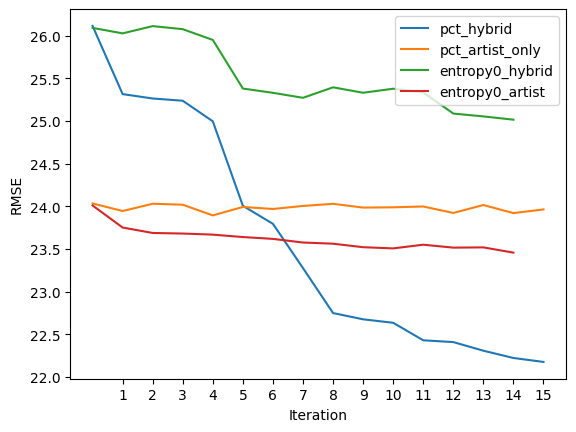

In [64]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_hybrid[0])), pct_hybrid[0], label='pct_hybrid')
ax1.plot(np.arange(len(pct_artist_only[0])), pct_artist_only[0], label='pct_artist_only')
ax1.plot(np.arange(len(entropy0_hybrid[0])), entropy0_hybrid[0], label='entropy0_hybrid')
ax1.plot(np.arange(len(entropy0_artist[0])), entropy0_artist[0], label='entropy0_artist')
# ax1.plot(x, pct_2[0], label='pct_2')
# ax1.plot(x, pct_3[0], label='pct_3')

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

## 20% warm

## 30% warm

## 40% warm

## 50% warm

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Step 1: Prepare data
df = train_with_meta.copy()
# drop "album', 'track" items before all processing
df = train_with_meta[~train_with_meta['item_type'].isin(['album', 'track'])].copy()

# Encode user_id and item_id to indices
user_ids = np.sort(df['user_id'].unique())
item_ids = np.sort(df['item_id'].unique())

user_id_map = {uid: i for i, uid in enumerate(user_ids)}
item_id_map = {iid: i for i, iid in enumerate(item_ids)}

# Step 2: Create user-item sparse rating matrix manually
row_indices = df['user_id'].map(user_id_map)
col_indices = df['item_id'].map(item_id_map)
ratings = df['rating'].astype(float)

n_users = len(user_ids)
n_items = len(item_ids)

user_item_sparse = csr_matrix((ratings, (row_indices, col_indices)), shape=(n_users, n_items))

# Step 3: Select core users (or choose active users manually)
np.random.seed(7)
core_indices = np.random.choice(n_users, size=5, replace=False)

# Step 4: Compute cosine similarity between core users and all users
sim_matrix = cosine_similarity(user_item_sparse[core_indices], user_item_sparse)
max_sim = sim_matrix.max(axis=0)

# Step 5: Pick top-K most similar users
top_k = 50000
top_user_indices = np.argsort(max_sim)[-top_k:]
sampled_user_ids = user_ids[top_user_indices]

# Step 6: Filter original data
user_filtered_df = df[df['user_id'].isin(sampled_user_ids)]

# Step 7: Summary
print(f"🎯 Sample shape: {user_filtered_df.shape}")
print(f"👤 Users: {user_filtered_df['user_id'].nunique()}, 🎵 Items: {user_filtered_df['item_id'].nunique()}")